In [15]:
%pip install torch torchvision torchaudio   # with GPU support
%pip install tensorflow                     # GPU build if available
%pip install jax jaxlib                    # GPU build if available
%pip install triton
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [16]:
import torch

import triton
import triton.language as tl

import triton
print(triton.__version__)
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

3.1.0
Thu Jan 30 09:40:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------

In [17]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
1
Tesla T4


In [14]:
import math
import torch
import triton
import triton.language as tl

# Kernel for Vector Addition

@triton.jit
def vector_add_kernel(
    A_ptr,  # pointer to first vector
    B_ptr,  # pointer to second vector
    C_ptr,  # pointer to output
    N,      # number of elements
    BLOCK_SIZE: tl.constexpr
):
    # Program ID (which block index in 1D)
    pid = tl.program_id(axis=0)

    start = pid * BLOCK_SIZE
    offsets = start + tl.arange(0, BLOCK_SIZE)

    # Out-of-bounds mask
    mask = offsets < N

    # Load
    a_vals = tl.load(A_ptr + offsets, mask=mask, other=0.0)
    b_vals = tl.load(B_ptr + offsets, mask=mask, other=0.0)

    # Compute
    c_vals = a_vals + b_vals

    # Store
    tl.store(C_ptr + offsets, c_vals, mask=mask)

def triton_vector_add(A: torch.Tensor, B: torch.Tensor, block_size=1024):
    """
    Adds two 1D CUDA Tensors (A + B) using our custom Triton kernel.
    :param A: torch.Tensor (on GPU)
    :param B: torch.Tensor (on GPU)
    :param block_size: Triton thread block size
    :return: C (torch.Tensor on GPU), same shape as A and B
    (Both A and B have same shapes)
    """
    assert A.is_cuda and B.is_cuda, "Tensors must be on GPU"
    assert A.shape == B.shape, "Shapes must match"

    N = A.numel()
    C = torch.empty_like(A)

    # 1D grid: how many blocks needed
    grid = (math.ceil(N / block_size), )

    # Launch the kernel
    vector_add_kernel[grid](
        A, B, C, N,
        BLOCK_SIZE=block_size,
    )
    return C


In [15]:
# Benchmarking

# benchmark_all.py
import time
import math
import numpy as np
import torch
import jax
import tensorflow as tf
import matplotlib.pyplot as plt

###############################################################################
# Benchmarking Functions
###############################################################################
def benchmark_pytorch(A_gpu, B_gpu):
    """PyTorch GPU: C = A + B."""
    torch.cuda.synchronize()
    start = time.perf_counter()
    C = A_gpu + B_gpu
    torch.cuda.synchronize()
    return time.perf_counter() - start

def benchmark_triton(A_gpu, B_gpu, block_size):
    """Triton custom kernel, GPU."""
    torch.cuda.synchronize()
    start = time.perf_counter()
    C = triton_vector_add(A_gpu, B_gpu, block_size=block_size)
    torch.cuda.synchronize()
    return time.perf_counter() - start

# JAX: define a jit-compiled function
@jax.jit
def jax_vector_add(A, B):
    return A + B

def benchmark_jax(A_cpu_np, B_cpu_np):
    """
    JAX addition on GPU.
    We must first move CPU data -> JAX device array (GPU).
    """
    # Convert to JAX device array
    A_jax = jax.device_put(A_cpu_np)
    B_jax = jax.device_put(B_cpu_np)
    # Warm-up to compile
    _ = jax_vector_add(A_jax, B_jax).block_until_ready()
    # Real timing
    start = time.perf_counter()
    C_jax = jax_vector_add(A_jax, B_jax)
    jax.block_until_ready(C_jax)
    return time.perf_counter() - start

@tf.function
def tf_add(a, b):
    return a + b

def benchmark_tensorflow(A_cpu_np, B_cpu_np):
    """
    TensorFlow addition.
    If TF is installed with GPU support, by default it should place
    float32 ops on GPU. We'll confirm by device placement logs or usage.
    """
    A_tf = tf.constant(A_cpu_np, dtype=tf.float32)
    B_tf = tf.constant(B_cpu_np, dtype=tf.float32)

    # Warm-up (trigger graph building if in @tf.function)
    _ = tf_add(A_tf, B_tf)

    # Real timing
    start = time.perf_counter()
    C_tf = tf_add(A_tf, B_tf)
    # Force synchronous read
    _ = C_tf.numpy()
    return time.perf_counter() - start

def benchmark_numpy(A_cpu_np, B_cpu_np):
    """NumPy CPU addition."""
    start = time.perf_counter()
    C_np = A_cpu_np + B_cpu_np
    return time.perf_counter() - start



In [20]:
def main():
    # Vector sizes
    vector_sizes = [100_000, 500_000, 1_000_000, 5_000_000]
    # Triton block sizes
    triton_block_sizes = [128, 256, 512, 1024, 2048]

    # We'll store raw times in dictionaries.
    # Key = vector size -> time in seconds
    # For Triton, we store times in a nested dict by block size:
    #   results_triton[block_size][vector_size] = time
    results_torch = {}
    results_tf = {}
    results_jax = {}
    results_numpy = {}
    results_triton = {bs: {} for bs in triton_block_sizes}

    #-------------------------
    # 1) Run the Benchmarks
    #-------------------------
    for size in vector_sizes:
        # Prepare random data on CPU
        A_cpu_np = np.random.randn(size).astype(np.float32)
        B_cpu_np = np.random.randn(size).astype(np.float32)

        # Also put on torch GPU for PyTorch + Triton
        A_torch = torch.tensor(A_cpu_np, device='cuda')
        B_torch = torch.tensor(B_cpu_np, device='cuda')

        # ============== PyTorch ==============
        pt_time = benchmark_pytorch(A_torch, B_torch)
        results_torch[size] = pt_time

        # ============== TensorFlow ==============
        tf_time = benchmark_tensorflow(A_cpu_np, B_cpu_np)
        results_tf[size] = tf_time

        # ============== JAX ==============
        jax_time = benchmark_jax(A_cpu_np, B_cpu_np)
        results_jax[size] = jax_time

        # ============== NumPy (CPU) ==============
        np_time = benchmark_numpy(A_cpu_np, B_cpu_np)
        results_numpy[size] = np_time

        # ============== Triton (multiple block sizes) ==============
        for bs in triton_block_sizes:
            tt_time = benchmark_triton(A_torch, B_torch, block_size=bs)
            results_triton[bs][size] = tt_time

    print("\n==================== Benchmark Results ====================")
    for size in vector_sizes:
        print(f"\nVector Size = {size}")
        print(f"  PyTorch (GPU)   : {results_torch[size]*1e3:8.3f} ms")
        print(f"  TensorFlow      : {results_tf[size]*1e3:8.3f} ms")
        print(f"  JAX (GPU)       : {results_jax[size]*1e3:8.3f} ms")
        print(f"  NumPy (CPU)     : {results_numpy[size]*1e3:8.3f} ms")
        # Triton block sizes
        for bs in triton_block_sizes:
            print(f"  Triton (BS={bs:4d}): {results_triton[bs][size]*1e3:8.3f} ms")

    #-------------------------
    # 3) Plot the Results
    #-------------------------
    plt.figure(figsize=(12, 5))

    # We'll create 2 subplots side by side.
    # (a) Left Subplot: Runtime vs. Vector Size (log-scaled X)
    # (b) Right Subplot: Triton-Only: Runtime vs. Block Size
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle("Vector Addition Benchmark", fontsize=16, fontweight='bold')

    # --- (a) Runtime vs. Vector Size ---
    # X-axis = vector_sizes, Y-axis = time in ms
    xs = vector_sizes

    # Plot PyTorch
    ax1.plot(xs, [results_torch[s]*1e3 for s in xs],
             marker='o', linestyle='--', label='PyTorch (GPU)')
    # Plot TensorFlow
    ax1.plot(xs, [results_tf[s]*1e3 for s in xs],
             marker='^', linestyle='--', label='TensorFlow')
    # Plot JAX
    ax1.plot(xs, [results_jax[s]*1e3 for s in xs],
             marker='s', linestyle='--', label='JAX (GPU)')
    # Plot NumPy
    ax1.plot(xs, [results_numpy[s]*1e3 for s in xs],
             marker='x', linestyle='--', label='NumPy (CPU)')

    # Plot Triton lines for different block sizes
    markers = ['o', 'v', '^', '<', '>']  # just for variety
    for i, bs in enumerate(triton_block_sizes):
        ax1.plot(xs,
                 [results_triton[bs][s]*1e3 for s in xs],
                 marker=markers[i % len(markers)],
                 linestyle='-',
                 label=f"Triton (BS={bs})")

    ax1.set_title("Runtime vs. Vector Size")
    ax1.set_xlabel("Vector Size (# elements)")
    ax1.set_ylabel("Time (ms)")
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.legend()

    # --- (b) Triton: Runtime vs. Block Size ---
    # We'll show one line per vector size
    for size in vector_sizes:
        times_ms = [results_triton[bs][size]*1e3 for bs in triton_block_sizes]
        ax2.plot(triton_block_sizes, times_ms,
                 marker='o', linestyle='--',
                 label=f"Size={size}")

    ax2.set_title("Triton: Runtime vs. BLOCK_SIZE")
    ax2.set_xlabel("BLOCK_SIZE")
    ax2.set_ylabel("Time (ms)")
    ax2.set_xscale('log')  # since block sizes are typically powers of 2
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig("benchmark_plots.png", dpi=150)
    # plt.show()  # Uncomment to display interactively

    print("\nPlots saved to 'benchmark_plots.png'.")
    print("Done!")


==================== Benchmark Results ====================

Vector Size = 100000
  PyTorch (GPU)   :    0.106 ms
  TensorFlow      :    0.923 ms
  JAX (GPU)       :    0.173 ms
  NumPy (CPU)     :    0.071 ms
  Triton (BS= 128):    0.164 ms
  Triton (BS= 256):    0.068 ms
  Triton (BS= 512):    0.051 ms
  Triton (BS=1024):    0.047 ms
  Triton (BS=2048):    0.045 ms

Vector Size = 500000
  PyTorch (GPU)   :    0.062 ms
  TensorFlow      :    1.472 ms
  JAX (GPU)       :    0.213 ms
  NumPy (CPU)     :    0.365 ms
  Triton (BS= 128):    0.154 ms
  Triton (BS= 256):    0.073 ms
  Triton (BS= 512):    0.063 ms
  Triton (BS=1024):    0.070 ms
  Triton (BS=2048):    0.065 ms

Vector Size = 1000000
  PyTorch (GPU)   :    0.112 ms
  TensorFlow      :    2.217 ms
  JAX (GPU)       :    0.223 ms
  NumPy (CPU)     :    0.727 ms
  Triton (BS= 128):    0.194 ms
  Triton (BS= 256):    0.124 ms
  Triton (BS= 512):    0.104 ms
  Triton (BS=1024):    0.093 ms
  Triton (BS=2048):    0.104 ms

Vector 

<Figure size 1200x500 with 0 Axes>

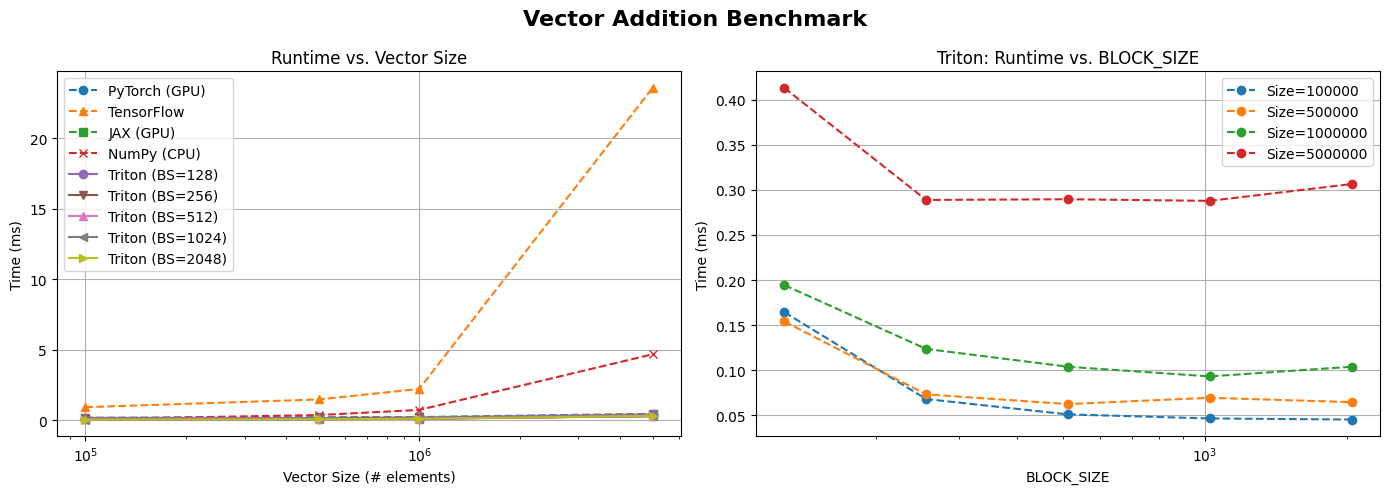

In [21]:
main()